## Hazırlayan: https://github.com/Frightera

# Makine Öğrenmesinde Veri Sızıntısı (Data Leakage) Nedir?

Data Leakage, eğitim veri seti dışındaki bilginin modelin oluşturulması sırasında kullanılması durumunda ortaya çıkar. Bu, modele ek bir bilgi sağlayabilir ve aslında bu ek bilginin model tarafından bilinmemesi gerekir. Neticede model öğrenmemesi gerektiği bir özellik öğrendiğinde bu modelin performansını çok kolay bir şekilde geçersiz kılabilir."

Yani yapılan bu hata (Data Leakage), aşırı iyimser veya gerçek hayatta bir işe yaramayacak modeller oluşturmanıza neden olabilir.

## İçindekiler
#### Kütüphanelerin Import Edilmesi
#### Verinin Okunması
#### Pipeline İçin Sütunların Belirlenmesi
#### Hatalı Pipeline - Data Leak Gösterimi
#### Doğru Pipeline Kurma - Pipeline Object
#### Aynı Adımlar fakat Pipeline Class'ı Olmadan

## Kütüphanelerin Import Edilmesi

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib as mpl
import seaborn as sns

plt = mpl.pyplot

import sklearn
import imblearn as imb

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score


from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, \
                                  RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC as Model

from imblearn.pipeline import Pipeline as imbalancedPipeline
from imblearn.over_sampling import SMOTE

for lib in [pd, np, sklearn, sns, mpl, imb]:
    print(lib.__name__, lib.__version__)

pandas 1.4.3
numpy 1.22.4
sklearn 1.1.2
seaborn 0.12.2
matplotlib 3.5.3
imblearn 0.10.1


## Verinin Okunması
Veri linki: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.drop('id', axis=1, inplace=True)

data_copy = data.copy() # pipeline gösterimi için
data_copy2 = data.copy() # pipeline'sız gösterim için

data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


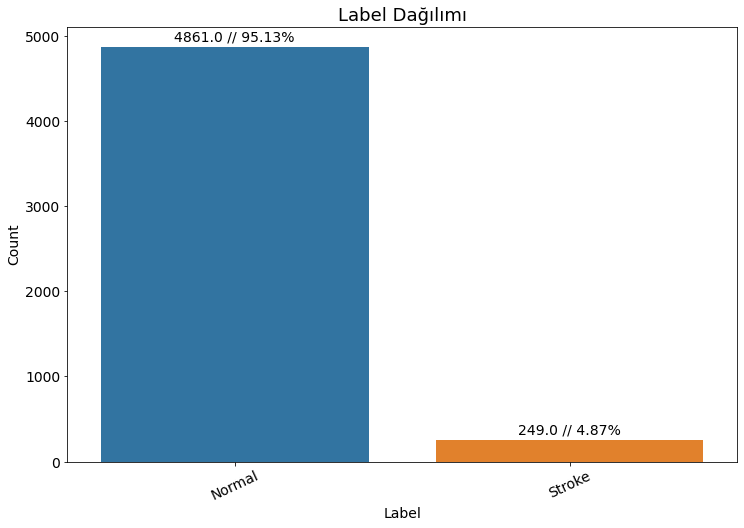

In [3]:
# Dengesiz verisetinin labellarının sayılıp görselleştirilmesi.
plt.figure(figsize = (12, 8))
sns.countplot(data = data, x = 'stroke')
plt.title('Label Dağılımı', size=18)
plt.xticks([0, 1], ['Normal', 'Stroke'], size=14, rotation=25)
plt.yticks(size=14)
plt.xlabel('Label', size=14)
plt.ylabel('Count', size=14)

for p in plt.gca().patches:
    percentage = f"{p.get_height() / data.shape[0] * 100:.2f}%"

    plt.gca().annotate(f"{p.get_height()} // {percentage}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       fontsize=14, color='black',
                       xytext=(0, 10), textcoords='offset points')

## Pipeline İçin Sütunların Belirlenmesi

In [4]:
# Eksik değer içeren sütunlar
missing_cols = [col for col in data.columns if data[col].isnull().any()]
missing_cols

['bmi']

In [5]:
# Numeric olmayan sütunlar.
# Bunların içinde kategorik olup, integer ile encode edilmiş columnlar dahil değildir.
# Mevcut pipeline planımıza göre 0 ve 1'lerden oluşan sütunlara dokunmayacağız.
# 0, 1, 2 ..., n farklı değer içeren kategorik columnlara one-hot-encoding uygulayacağız.
non_numerical_cols = [col for col in data.columns if data[col].dtype == 'object']
non_numerical_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [6]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]

only_2_unique_val = [col for col in non_numerical_cols if data[col].nunique() == 2]
rest_categorical_cols = list(set(non_numerical_cols) - set(only_2_unique_val))

no_op_cols = list(set(data.columns) - set(non_numerical_cols) - set(missing_cols) - set(numerical_cols) - {'stroke'})

print(f"Sadece 2 eşsiz değer içerenler: {only_2_unique_val}")
print(f"Geri kalan kategorik sütunlar: {rest_categorical_cols}")
print(f"İşlem yapılmayacaklar: {no_op_cols}")

Sadece 2 eşsiz değer içerenler: ['ever_married', 'Residence_type']
Geri kalan kategorik sütunlar: ['work_type', 'gender', 'smoking_status']
İşlem yapılmayacaklar: ['hypertension', 'heart_disease']


In [7]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Hatalı Pipeline - Data Leak Gösterimi
* Train-Test split yapmadan:
  * Eksik değerlerin mean-mode-median vb. ile doldurulması,
  * Kategorik sütunların encode edilmesi,
  * Kategorik sütunların bazılarına one-hot-encoding uygunlanması,
  * Verinin scale edilmesi
  * SMOTE uygulanması
vb. adımlar bir data-leak örneğidir. Bu adımların herhangir birisinin yine tek başına uygulanması bir data-leak'e sebebiyet verecektir. 

<br>

* Cross validation için durum daha farklıdır:
  * Her train ve validation fold'unu ayrı ayrı train-test mantığıyla düşünmek gerekir.

<br>

* Aşağıda yapılan hataları adım adım burada toplayacak olursak:
  * Direkt mean ile eksik değerlerin doldurulması,
  * Kategorik sütunların LabelEncoder ile encode edilmesi,
    * Bir döngü içinde sürekli fit_transform kullanılması,
  * One-hot-encoding için pd.get_dummies kullanılması,
  * Verinin scale edilmesinin sırasının yanlış olması ve
  * SMOTE'nin verinin tamamına uygulanması
şeklinde sıralanabilir.

In [8]:
# Eksik değerlerin mean ile doldurulması
data[missing_cols] = data[missing_cols].fillna(data[missing_cols].mean())

# Sadece 2 değer içeren sütunların encode edilmesi #
# Bilinenin aksine bunun için LabelEncoder kullanmak YANLIŞTIR.
# Sıklıkla yapılan hatalardan birisi de özellik sütunlarının
# LabelEncoder kullanılarak integer değerlere çevrilmesidir.
# İsminden de anlaşılacağı üzere label yani etiketler için
# kullanılmalıdır.
label_encoder = LabelEncoder()

for col in only_2_unique_val:
    # Bir diğer hata ise encode edecek obje üstüne sürekli
    # fit_transform kullanılmasıdır. 
    # Eğer encoder objesi çoklu sütunlar kaldıramıyorsa
    # döngü içinde her sütun için encoder objesi bir dict içinde saklanmalıdır.
    data[col] = label_encoder.fit_transform(data[col])

# pd.get_dummies bir pipeline için uygun değildir.
# Bunun yerine sklearnden one-hot-encoder kullanılmalıdır.
# Çünkü pd.get_dummies train-test ayrımı yapmadan one-hot-encoding yapar.
# Bizim amacımız trainde OHE yapıp, aynı mapping'i diğer splitlere uygulamaktır.
data = pd.get_dummies(data, columns=rest_categorical_cols)

# Verilerin scale edilmesinde sorun yok fakat sıra olarak yanlış.
robust_scaler = RobustScaler()

data[numerical_cols] = robust_scaler.fit_transform(data[numerical_cols])

data.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Female,gender_Male,gender_Other,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.611111,0,1,1,1,3.712987,0.911111,1,0,0,1,0,0,0,1,0,0,1,0,0
1,0.444444,0,0,1,0,2.994300,0.054804,1,0,0,0,1,0,1,0,0,0,0,1,0
2,0.972222,0,1,1,0,0.380920,0.455556,1,0,0,1,0,0,0,1,0,0,0,1,0
3,0.111111,0,0,1,1,2.153481,0.666667,1,0,0,1,0,0,1,0,0,0,0,0,1
4,0.944444,1,0,1,0,2.231917,-0.488889,1,0,0,0,1,0,1,0,0,0,0,1,0


In [9]:
features = data.drop('stroke', axis=1)
target = data['stroke']

# Sorunlardan en büyüğü olabilir, train-test ayrımı yapmadan SMOTE uygulanmaz.
smote = SMOTE(random_state=42)
features, target = smote.fit_resample(features, target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

for split in [X_train, X_test, y_train, y_test]:
    print(split.shape, split.isnull().sum().sum())

(7777, 19) 0
(1945, 19) 0
(7777,) 0
(1945,) 0


In [10]:
model = Model()

# 5 Fold CV - Bu cross-validation'ın hiçbir değeri yoktur.
# Çünkü izlenen adımlar tamamen yanlıştır. Bir şeylerin çalışıp
# skor üretiyor olması, doğru bir sonuç ürettiğini göstermez.

# Skorlar yüksek çıktı diye sevinelim mi?
cv_scores = cross_val_score(model,
                            X_train, 
                            y_train,
                            cv=5,
                            scoring="f1_macro")

for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1} score: {score * 100:.2f}%")

print("---" * 8)
print(f"Ortalama F1-Skoru: {cv_scores.mean() * 100:.2f}%")
print(f"Standart Sapma: {cv_scores.std() * 100:.2f}%")

Fold 1 score: 89.19%
Fold 2 score: 88.16%
Fold 3 score: 88.52%
Fold 4 score: 86.69%
Fold 5 score: 88.65%
------------------------
Ortalama F1-Skoru: 88.24%
Standart Sapma: 0.84%


In [11]:
model = Model()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
def plot_confusion_matrix(confusion_matrix):    
    plt.figure(figsize = (12, 8))
    sns.heatmap(confusion_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                linewidths=10,
                annot_kws={'size': 20}, cbar=False)

    plt.title('Confusion Matrix', size=18)
    plt.xticks([0.5, 1.5], ['Predicted Normal', 'Predicted Stroke'], size=14, rotation=25)
    plt.yticks([0.5, 1.5], ['Actual Normal', 'Actual Stroke'], size=14, rotation=25)
    plt.xlabel('Predicted Label', size=14)
    plt.ylabel('Actual Label', size=14)
    plt.show()

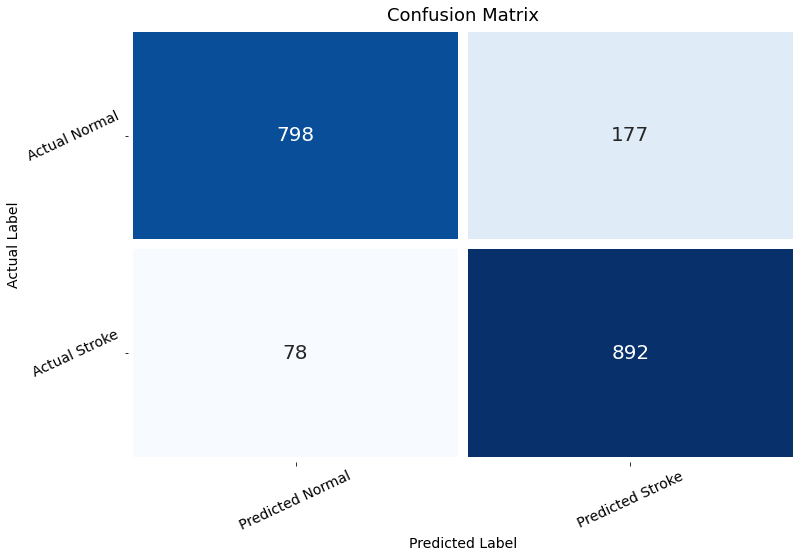

In [13]:
# Sonuçlar iyi görünüyor.
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### classification_reportta da güzel sonuçlar görmekteyiz fakat ne yazık ki bu model gerçek hayatta bu başarıyı gösteremeyecektir.

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       975
           1       0.83      0.92      0.87       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945



## Doğru Pipeline Kurma - Pipeline Object

#### Cross Validation yapacaksak doğru kullanım bu şekilde olmalıdır.

In [15]:
# Sklearn bünyesinde bulunan Pipeline class'ı data leak olmaması için 
# gerekli adımları doğru sırada uygulayacaktır.

# Her sütun için farklı işlemler yapacağımız için ayrı ayrı Pipeline
# içine koyabiliriz.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())])

# LabelEncoder yerine OrdinalEncoder kullanılmalıdır.
binary_transformer = Pipeline(steps=[
    ('binary', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# Get Dummies yerine de OneHotEncoder kullanımı doğrudur.
non_binary_transformer = Pipeline(steps=[
    ('non_binary', OneHotEncoder(handle_unknown='ignore'))
])

# Herhangi bir dönüşüm uygulayacaksak lambda fonksiyonu kullanabiliriz.
# Bu pipeline'a bir işlem uygulamayacağımız sütunları göndereceğiz.
no_op_transformer = Pipeline(steps=[
    ('no_op', FunctionTransformer(lambda x: x))
])

# Bütün bu pipelineların hepsini ColumnTransformer altında birleştirip
# hangi sütunlar üzerinde işlem yapacaksa o şekilde belirtebiliriz.
preprocessing_pipeline = ColumnTransformer(transformers=[
    # burada sadece missing değerler için ayrı bir pipeline açabilirdik,
    # daha da uzamaması için direkt numerical_cols verildi.
    ('numeric', numeric_transformer, numerical_cols),
    ('binary', binary_transformer, only_2_unique_val),
    ('non_binary', non_binary_transformer, rest_categorical_cols),
    ('no_op', no_op_transformer, no_op_cols)
])

# imblearn çatısı altındaki Pipeline class'ını kullanarak SMOTE'yi verebiliriz.
model_pipeline = imbalancedPipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('smote', SMOTE()),
    ('model', Model())
])

features = data_copy.drop('stroke', axis=1)
target = data_copy['stroke']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [16]:
# Pipeline class'ı doğru şekilde cross-validation'ı uygulayacak.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=skf,
                            scoring="f1_macro")

for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1} score: {score * 100:.2f}%")

print("---" * 8)
print(f"Ortalama F1-Skoru : {cv_scores.mean() * 100:.2f}%")
print(f"Standart Sapma: {cv_scores.std() * 100:.2f}%")

Fold 1 score: 55.37%
Fold 2 score: 51.20%
Fold 3 score: 52.97%
Fold 4 score: 52.44%
Fold 5 score: 53.18%
------------------------
Ortalama F1-Skoru : 53.03%
Standart Sapma: 1.36%


In [17]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

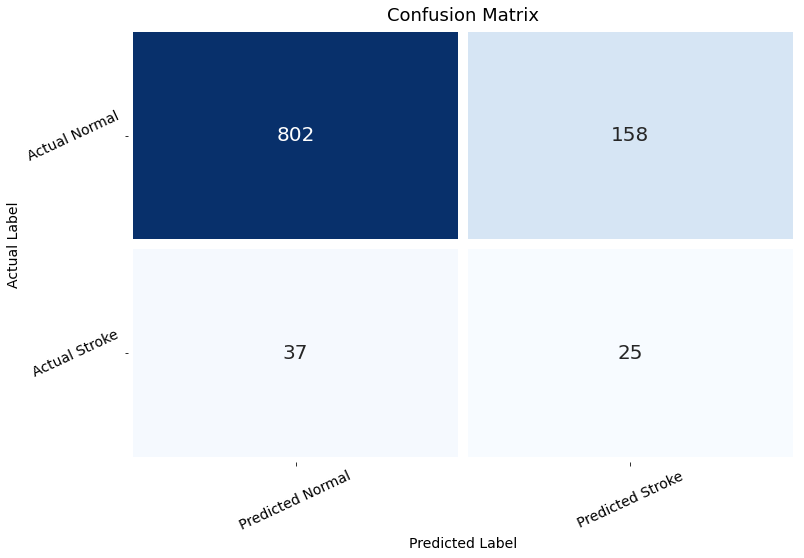

In [18]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Yukarıdaki sonuçlara nazaran daha kötü bir sonuç elde ettik fakat data leak olmadan doğru bir şekilde pipeline kurmuş olduk.
#### Modelin gerçek hayattaki performansı bu şekilde olacak diyebiliriz. (Data Drift vb olmadan)
 * Data drift sonraki notebooklarda ele alınacaktır.

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       960
           1       0.14      0.40      0.20        62

    accuracy                           0.81      1022
   macro avg       0.55      0.62      0.55      1022
weighted avg       0.91      0.81      0.85      1022



## Aynı Adımlar fakat Pipeline Class'ı Olmadan

In [20]:
features, target = data_copy2.drop('stroke', axis=1), data_copy2['stroke']

In [21]:
# Cross val objesini oluşturuyoruz.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

cv_results = {}

for fold_no, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    
    # Train ve validasyon setlerini alıyoruz.
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    #########################################################################
    ##################Bundan sonraki adımlar çok önemli######################
    #########################################################################
    
    for missing_col in missing_cols:
        # Train foldlarında mean hesaplanır.
        train_mean = X_train_fold[missing_col].mean()
        
        # Val ve train aynı değerlerle doldurulur.
        X_train_fold.loc[:, missing_col] = X_train_fold.loc[:, missing_col].fillna(train_mean)
        X_val_fold.loc[:, missing_col] = X_val_fold.loc[:, missing_col].fillna(train_mean)

    scaler = RobustScaler()
    # Sadece TRAIN fit_transform!!
    X_train_fold.loc[:, numerical_cols] = scaler.fit_transform(X_train_fold.loc[:, numerical_cols])
    # Test ve val setleri TRANSFORM!!
    X_val_fold.loc[:, numerical_cols] = scaler.transform(X_val_fold.loc[:, numerical_cols])
    
    # Encoding kısmı
    for col in only_2_unique_val:
        # Encoder objesi oluşturulur.
        # Train splitinde görülmemiş bir değer varsa -1 olarak dönüştürüyor.
        # pd.get_dummies ile bu mümkün değildir.
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        
        # Dikkat ederseniz scalerda da olduğu gibi sadece train fit_transform.
        # Validation için transform methodunu kullanıyoruz.
        X_train_fold.loc[:, col] = encoder.fit_transform(X_train_fold.loc[:, col].values.reshape(-1, 1))
        X_val_fold.loc[:, col] = encoder.transform(X_val_fold.loc[:, col].values.reshape(-1, 1))

    # One-hot-encoder kullanımı
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    # Train için sadece fit edip sonra sürekli transform methodu da kullanılabilir.
    ohe.fit(X_train_fold[rest_categorical_cols])
    
    # Sorun şu ki, transform diyince elimizde farklı bir dataframe oluyor, bunu da öncekiyle
    # concat etmemiz lazım.
    train_ohe = pd.DataFrame(ohe.transform(X_train_fold[rest_categorical_cols]).toarray(), 
                             columns=ohe.get_feature_names_out(rest_categorical_cols))
    
    val_ohe = pd.DataFrame(ohe.transform(X_val_fold[rest_categorical_cols]).toarray(),
                           columns=ohe.get_feature_names_out(rest_categorical_cols))
    
    X_train_fold = pd.concat([X_train_fold.reset_index(drop=True), 
                              train_ohe.reset_index(drop=True)], axis=1)
    X_val_fold = pd.concat([X_val_fold.reset_index(drop=True), 
                            val_ohe.reset_index(drop=True)], axis=1)
    
    # OHE işleminden sonra fazla sütunları drop etmeliyiz, çünkü OHE df ve öncekini birleştirdik.
    X_train_fold = X_train_fold.drop(rest_categorical_cols, 
                                     axis=1)
    X_val_fold = X_val_fold.drop(rest_categorical_cols,
                                 axis=1)

    # SMOTE kullanmaya hazırız.
    # Sadece train setinde uygulamalıyız, modelin performansı yine kalan orijinal örnekler
    # üzerinden değerlendirilmeli.
    sm = SMOTE()
    X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)

    model = Model()
    
    # Fit ve predict
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    # Skorların hesaplanıp, saklanması
    f1_score_fold = f1_score(y_val_fold, y_pred, average='macro')
    cv_results[fold_no] = f1_score_fold

    print(f"Fold {fold_no + 1} score: {f1_score_fold * 100:.2f}%")

Fold 1 score: 53.71%
Fold 2 score: 51.69%
Fold 3 score: 53.22%
Fold 4 score: 51.96%
Fold 5 score: 52.16%


In [22]:
# Ortalama F1-Skoru görüldüğü üzere Pipeline kullanımı ile yakın çıktı.
# Pipeline class'ı bu adımları bizim için arka planda ayarlamış oluyor.
(sum(cv_results.values()) / len(cv_results)).round(4)

0.5255